In [2]:
from subprocess import check_output
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from Bio import SeqIO
from Bio.SeqIO import SeqRecord 


In [3]:
# I've checked, actually, no tRNAs was found, and this hit was produced by the word 'tRNA' in the description of some protein.

words = ["CDS", "tRNA", "rRNA", "hypothetical protein"]
for word in words:
    res = check_output(f'grep "{word}" annotation_prokka/PROKKA_10132020.gff | wc -l', shell=True).decode().strip()
    print(f'{word}: {res}')

CDS: 36
tRNA: 1
rRNA: 0
hypothetical protein: 16


In [4]:
# Looking for operons

in_folder = Path("annotation_prokka/")
with (in_folder/Path("PROKKA_10132020.gff")).open("r") as fl:
    lines = list(filter(lambda line: "CDS" in line, fl.readlines()))

print(len(lines))
plus_lines = list(filter(lambda line: line.split()[6] == "+", lines))
minus_lines = list(filter(lambda line: line.split()[6] == "-", lines))
all_genes = []
all_operons = []
for lines in (plus_lines, minus_lines):    
    genes = [(int(line.split()[3]), int(line.split()[4]), line.split("product=")[1].strip()) for line in lines]
    if lines == plus_lines:
        symbol = "+"
    else:
        symbol = "-"
    all_genes.append([genes, symbol])
    operons = [[genes[0]]]
    for gene in genes[1:]:
        if gene[0] - operons[-1][-1][1] < 150:
            operons[-1].append(gene)
        else:
            operons.append([gene])
    operons = list(filter(lambda operon: len(operon) > 2, operons))
    for operon in operons:
        print([gene[2] for gene in operon])
        all_operons.append((operon[0][0], operon[-1][1]))


36
['hypothetical protein', '2-C-methyl-D-erythritol 4-phosphate cytidylyltransferase', 'SPBc2 prophage-derived endonuclease YokF', 'hypothetical protein', 'hypothetical protein', 'General stress protein 69']
['Flagellar motor switch protein FliN', '3-oxoacyl-[acyl-carrier-protein] synthase 2', 'Acyl carrier protein']
['hypothetical protein', 'Histidine biosynthesis bifunctional protein HisB', 'Undecaprenol kinase', 'hypothetical protein']


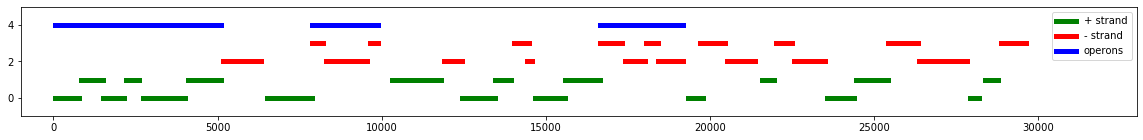

In [130]:
# Visualizing CDSs and operons.

fig, ax = plt.subplots(figsize=(20, 2))
colors = {"+": "green", "-": "red"}
for j, gene_group in enumerate(all_genes):
    genes, sign = gene_group
    color = colors[sign]
    for i, gene in enumerate(genes):
        label = None if i != len(genes)-1 else str(sign) + " strand"
        ax.plot(gene[:2], [(j*2 + i%2), (j*2 + i%2)], color=color, lw=5, label=label)
for i, operon in enumerate(all_operons):
    label  = None if i != len(all_operons)-1 else "operons"
    ax.plot(operon, [4, 4], color="blue", lw=5,label=label)
ax.set(ylim=(-1, 5), xlim=(-1000, 33000))
ax.legend()
fig.savefig("genes_along_genome.png")

In [143]:
# Creating files for blast

Path("CDS/").mkdir(exist_ok=True)

with (in_folder/Path("PROKKA_10132020.gff")).open("r") as fl:
    lines = list(filter(lambda line: "CDS" in line, fl.readlines()))
for line in lines:
    ID = line.split("=")[1].split(";")[0]
    strand, start, stop, product = line.split()[6], int(line.split()[3])-1, int(line.split()[4]), line.split("product=")[1].strip() 
#     print(ID, strand, start, stop, product)
    if strand == "+":
        sequence = genome.seq[start:stop]
    elif strand == "-":
        sequence = genome.seq[start:stop].reverse_complement()
    record = SeqRecord(id=ID, seq=sequence, description=product)
    SeqIO.write(record, f"CDS/{ID}.fasta", format="fasta")

In [157]:
#Let's try nblast

from Bio.Blast.NCBIWWW import qblast
outdir = Path("blast_out/")
outdir.mkdir(exist_ok=True)
blasted = [file.stem for file in outdir.glob("*")]
for file in Path("CDS/").glob("*"):
    print(file)
    if file.stem in blasted:
        continue
    seq = SeqIO.read(file, format="fasta").seq
    res = qblast(program="blastn",
                 database="nr",
             sequence=seq, 
                 megablast=True)
    with open(str(outdir/Path(f"{file.stem}.xml")), "w") as fl:
        fl.write(res.read())


CDS/GFKBJCAA_00006.fasta
CDS/GFKBJCAA_00011.fasta
CDS/GFKBJCAA_00035.fasta
CDS/GFKBJCAA_00013.fasta
CDS/GFKBJCAA_00008.fasta
CDS/GFKBJCAA_00003.fasta
CDS/GFKBJCAA_00020.fasta
CDS/GFKBJCAA_00007.fasta
CDS/GFKBJCAA_00010.fasta
CDS/GFKBJCAA_00026.fasta
CDS/GFKBJCAA_00014.fasta
CDS/GFKBJCAA_00018.fasta
CDS/GFKBJCAA_00030.fasta
CDS/GFKBJCAA_00002.fasta
CDS/GFKBJCAA_00029.fasta
CDS/GFKBJCAA_00004.fasta
CDS/GFKBJCAA_00009.fasta
CDS/GFKBJCAA_00015.fasta
CDS/GFKBJCAA_00032.fasta
CDS/GFKBJCAA_00028.fasta
CDS/GFKBJCAA_00024.fasta
CDS/GFKBJCAA_00019.fasta
CDS/GFKBJCAA_00016.fasta
CDS/GFKBJCAA_00001.fasta
CDS/GFKBJCAA_00021.fasta
CDS/GFKBJCAA_00036.fasta
CDS/GFKBJCAA_00005.fasta
CDS/GFKBJCAA_00034.fasta
CDS/GFKBJCAA_00031.fasta
CDS/GFKBJCAA_00027.fasta
CDS/GFKBJCAA_00017.fasta
CDS/GFKBJCAA_00023.fasta
CDS/GFKBJCAA_00022.fasta
CDS/GFKBJCAA_00025.fasta
CDS/GFKBJCAA_00012.fasta
CDS/GFKBJCAA_00033.fasta


In [6]:
# Making df out of blastn results

from Bio.Blast import NCBIXML

df = pd.DataFrame(columns=["ID", "log10_e_val", "seq_length", "seq_identity", "annotation", "best_hit", "organism"])

outfiles = list(filter(lambda el: el.stat().st_size > 1865, list(Path("blast_out/").glob("*"))))
infiles = list(filter(lambda el: el.stem in [file.stem for file in outfiles], list(Path("CDS/").glob("*"))))
print(f"{len(outfiles)} files were found by blastn")
i = 0
for outfile in outfiles:
    infile = list(filter(lambda file: file.stem == outfile.stem, infiles))[0]
    initial_seq_length = len(SeqIO.read(infile, format="fasta").seq)
    initial_seq_descrption = SeqIO.read(infile, format="fasta").description
    initial_seq_descrption = " ".join(initial_seq_descrption.split()[1:])
    parser = NCBIXML.parse(open(outfile))
    for record in parser:
        align = min(record.alignments, key=lambda el: min([hsp.expect for hsp in el.hsps]))
        hsp = min(align.hsps, key=lambda el: el.expect)
        new_row = [infile.stem, 
              np.log10(align.hsps[0].expect).round(), 
              initial_seq_length, 
              hsp.identities,
              initial_seq_descrption,
              align.hit_def, " ".join(align.hit_def.split()[:2])]
        df.loc[i] = new_row
        i+=1
df.to_csv("blastn_results.csv", index=False)
df

7 files were found by blastn


,ID,log10_e_val,seq_length,seq_identity,annotation,best_hit,organism
0,GFKBJCAA_00014,-5.0,1017,40,Epoxyqueuosine reductase,Caldilinea aerophila DSM 14535 = NBRC 104270 D...,Caldilinea aerophila
1,GFKBJCAA_00028,-19.0,483,87,putative peptidyl-prolyl cis-trans isomerase,Stenotrophomonas rhizophila strain DSM14405 ge...,Stenotrophomonas rhizophila
2,GFKBJCAA_00027,-5.0,384,35,Aspartate 1-decarboxylase,"Deinococcus deserti VCD115, complete genome",Deinococcus deserti
3,GFKBJCAA_00033,-7.0,1464,38,L-Rhamnulokinase,"Candidatus Solibacter usitatus Ellin6076, comp...",Candidatus Solibacter
4,GFKBJCAA_00006,-3.0,1020,44,General stress protein 69,"Hymenobacter sp. DG25A, complete genome",Hymenobacter sp.
5,GFKBJCAA_00026,-9.0,867,78,Branched-chain-amino-acid aminotransferase,"Candidatus Acetothermus autotrophicum DNA, lar...",Candidatus Acetothermus
6,GFKBJCAA_00010,-20.0,1242,154,3-oxoacyl-[acyl-carrier-protein] synthase 2,"Aeromonas salmonicida strain O23A chromosome, ...",Aeromonas salmonicida


In [14]:
### Let's try tblastx
from Bio.Blast.NCBIWWW import qblast
outdir = Path("tblastx_out/")
outdir.mkdir(exist_ok=True)
blasted = [file.stem for file in outdir.glob("*")]
for file in Path("CDS/").glob("*"):
    print(file)
    if file.stem in blasted:
        continue
    seq = SeqIO.read(file, format="fasta").seq
    try:
        res = qblast(program="tblastx",
                 database="nr",
             sequence=seq, 
                 megablast=True)
    except ValueError:
        pass
    with open(str(outdir/Path(f"{file.stem}.xml")), "w") as fl:
        fl.write(res.read())

CDS/GFKBJCAA_00006.fasta
CDS/GFKBJCAA_00011.fasta
CDS/GFKBJCAA_00035.fasta
CDS/GFKBJCAA_00013.fasta
CDS/GFKBJCAA_00008.fasta
CDS/GFKBJCAA_00003.fasta
CDS/GFKBJCAA_00020.fasta
CDS/GFKBJCAA_00007.fasta
CDS/GFKBJCAA_00010.fasta
CDS/GFKBJCAA_00026.fasta
CDS/GFKBJCAA_00014.fasta
CDS/GFKBJCAA_00018.fasta
CDS/GFKBJCAA_00030.fasta
CDS/GFKBJCAA_00002.fasta
CDS/GFKBJCAA_00029.fasta
CDS/GFKBJCAA_00004.fasta
CDS/GFKBJCAA_00009.fasta
CDS/GFKBJCAA_00015.fasta
CDS/GFKBJCAA_00032.fasta
CDS/GFKBJCAA_00028.fasta
CDS/GFKBJCAA_00024.fasta
CDS/GFKBJCAA_00019.fasta
CDS/GFKBJCAA_00016.fasta
CDS/GFKBJCAA_00001.fasta
CDS/GFKBJCAA_00021.fasta
CDS/GFKBJCAA_00036.fasta
CDS/GFKBJCAA_00005.fasta
CDS/GFKBJCAA_00034.fasta
CDS/GFKBJCAA_00031.fasta
CDS/GFKBJCAA_00027.fasta
CDS/GFKBJCAA_00017.fasta
CDS/GFKBJCAA_00023.fasta
CDS/GFKBJCAA_00022.fasta
CDS/GFKBJCAA_00025.fasta
CDS/GFKBJCAA_00012.fasta
CDS/GFKBJCAA_00033.fasta


In [7]:
# Making df out of tblastx results


from Bio.Blast import NCBIXML

df_tblastx = pd.DataFrame(columns=["ID", "log10_e_val", "seq_length", "seq_identity", "annotation", "best_hit", "organism"])

outfiles = list(filter(lambda el: el.stat().st_size > 2090, list(Path("tblastx_out/").glob("*"))))
infiles = list(filter(lambda el: el.stem in [file.stem for file in outfiles], list(Path("CDS/").glob("*"))))
print(f"{len(outfiles)} files were found by tblastx")
i = 0
for outfile in outfiles:
    infile = list(filter(lambda file: file.stem == outfile.stem, infiles))[0]
    initial_seq_length = len(SeqIO.read(infile, format="fasta").seq)
    initial_seq_descrption = SeqIO.read(infile, format="fasta").description
    initial_seq_descrption = " ".join(initial_seq_descrption.split()[1:])
    parser = NCBIXML.parse(open(outfile))
    for record in parser:
        if not record.alignments:
            continue
        align = min(record.alignments, key=lambda el: min([hsp.expect for hsp in el.hsps]))
        hsp = min(align.hsps, key=lambda el: el.expect)
        new_row = [infile.stem, 
              np.log10(align.hsps[0].expect).round(), 
              initial_seq_length, 
              hsp.identities,
              initial_seq_descrption,
              align.hit_def, " ".join(align.hit_def.split()[:2])]
#                   record.alignments[0]]
        df_tblastx.loc[i] = new_row
        i+=1
df_tblastx.to_csv("tblastx_results.csv", index=False)
df_tblastx

15 files were found by tblastx


,ID,log10_e_val,seq_length,seq_identity,annotation,best_hit,organism
0,GFKBJCAA_00016,-27.0,438,57,18 kDa heat shock protein,"Roseimaritima ulvae strain UC8 chromosome, com...",Roseimaritima ulvae
1,GFKBJCAA_00009,-17.0,309,37,Flagellar motor switch protein FliN,"Phycisphaerae bacterium RAS2 chromosome, compl...",Phycisphaerae bacterium
2,GFKBJCAA_00034,0.0,267,16,hypothetical protein,Lateolabrax maculatus linkage group 8 sequence,Lateolabrax maculatus
3,GFKBJCAA_00027,-36.0,384,68,Aspartate 1-decarboxylase,"Planctomycetales bacterium zrk34 chromosome, c...",Planctomycetales bacterium
4,GFKBJCAA_00017,-1.0,174,15,hypothetical protein,"Pseudomonas rhizosphaerae strain DSM 16299, co...",Pseudomonas rhizosphaerae
5,GFKBJCAA_00013,-54.0,531,103,Orotate phosphoribosyltransferase,"Phycisphaerae bacterium ST-NAGAB-D1, complete ...",Phycisphaerae bacterium
6,GFKBJCAA_00024,-12.0,456,42,hypothetical protein,"Planctomycetales bacterium zrk34 chromosome, c...",Planctomycetales bacterium
7,GFKBJCAA_00022,-13.0,378,39,Undecaprenol kinase,Bacillus circulans strain FDAARGOS_783 chromos...,Bacillus circulans
8,GFKBJCAA_00026,-126.0,867,186,Branched-chain-amino-acid aminotransferase,"Thermogutta terrifontis strain R1, complete ge...",Thermogutta terrifontis
9,GFKBJCAA_00015,-13.0,480,35,hypothetical protein,"Methylococcus capsulatus str. Bath, complete g...",Methylococcus capsulatus


([<matplotlib.patches.Wedge at 0x7f4eea51c650>,
 [Text(0.33991867422268784, 1.0461621742897658, 'Planctomycetes'),
  Text(-0.9801071964785992, 0.499389510713692, 'fish'),
  Text(-0.7778174410990705, -0.7778174775113338, 'Proteobacteria'),
  Text(0.49938955659582074, -0.980107173100488, 'Firmicutes'),
  Text(0.7778174684082683, -0.7778174502021364, 'Chloroflexi'),
  Text(0.9801071847895435, -0.49938953365475724, 'Acidobacteria'),
  Text(1.086457178279648, -0.17207788865692558, 'Bacteroidetes')])

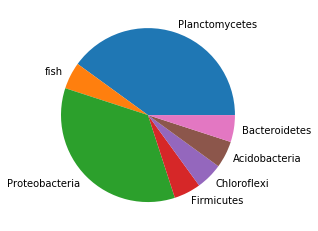

In [163]:
# Joining blast results

first = df_tblastx
first["method"] = "tblastx"
second = df
second["method"] = "blastn"
joint_df = first.append(second)
joint_df.drop_duplicates(subset="ID", keep="first", inplace=True)
joint_df.reset_index(inplace=True, drop=True)
joint_df.loc[joint_df.ID=="GFKBJCAA_00021", "organism"] = "Alpha proteobacteria"
joint_df["phylum"] =  ["Planctomycetes", 
"Planctomycetes",
"fish",
 "Planctomycetes",
 "Proteobacteria",
 "Planctomycetes",
 "Planctomycetes",
 "Firmicutes",
 "Planctomycetes",
 "Proteobacteria",
 "Planctomycetes",
 "Proteobacteria",
 "Proteobacteria",
 "Planctomycetes",
 "Proteobacteria",
 "Chloroflexi",
 "Proteobacteria",
 "Acidobacteria", # from https://microbewiki.kenyon.edu/
 "Bacteroidetes",
 "Proteobacteria"]
joint_df["HGT_candidate"] = (joint_df.phylum != "Planctomycetes")
joint_df["significant_hit_size"] = (joint_df.log10_e_val < -10)
# joint_df.loc[joint_df.HGT_candidate & joint_df.significant_hit_size]
presentable = joint_df.loc[:, ["ID",  "method", "log10_e_val", "annotation", "organism", "phylum"]].sort_values(by="ID", axis=0)
presentable.shape
# presentable.to_csv("Table3.csv", index=False)
from collections import Counter

c = Counter(joint_df["phylum"])
plt.pie(list(c.values()), labels=list(c.keys()))

In [275]:
### Translating genes into proteins

all_genes = list(SeqIO.parse("all_proteins.fasta", format="fasta"))
for gene in all_genes:
    gene.seq = gene.seq.translate()[:-1]
SeqIO.write(all_genes, "all_proteins_translated.fasta", format="fasta")

36

In [60]:
# Dealing with conserved domains

cd = pd.read_csv("conserved_domains.tsv", sep="\t", skiprows=7)

# Making this data frame a little prettier.
cd["Seq_ID"] = cd.Query.apply(lambda el: el.split(">")[1].split()[0])
cd["Prokka_annotation"] = cd.Query.apply(lambda el: " ".join(el.split(">")[1].split()[1:]).split("[")[0])
cd.drop("Query", axis=1, inplace=True)
cols = cd.columns.tolist()
cols = cols[-2:] + cols[:-2]
cd = cd[cols]


[43, 771, 'Domains: TauE', 'GFKBJCAA_00001']

In [103]:
# Making pretty Table 1 for the report

columns=["Prokka ID", "coordinates", "strand", "Prokka annotation", "Batch CD annotation"]
table1 = pd.DataFrame()
table1["Prokka ID"] = sorted([gene[3] for gene in all_genes[0][0] + all_genes[1][0]])

strand = dict()
coordinates = dict()
for gene in all_genes[0][0]:
    strand[gene[3]] = "+"
    coordinates[gene[3]] = str(gene[0]) + "-" + str(gene[1])
for gene in all_genes[1][0]:
    strand[gene[3]] = "-"
    coordinates[gene[3]] = str(gene[0]) + "-" + str(gene[1])

table1["coordinates"] = table1["Prokka ID"].map(coordinates)
table1["strand"] = table1["Prokka ID"].map(strand)

prokka_annotation = dict()
for gene in all_genes[0][0] + all_genes[1][0]:
    prokka_annotation[gene[3]] = "hypothetical protein" if "Domains" in gene[2] else gene[2]
table1["Prokka annotation"] = table1["Prokka ID"].map(prokka_annotation)
    
Batch_CD_annotation = dict()
for gene in table1["Prokka ID"]:
    batch_cd = "; ".join(list(cd.loc[cd.Seq_ID == gene, "Short name"]))
#     print(batch_cd)
    if batch_cd:
        Batch_CD_annotation[gene] = batch_cd
    else:
        Batch_CD_annotation[gene] = "-"
    
    
table1["Batch CD annotation"] = table1["Prokka ID"].map(Batch_CD_annotation)
    
table1.to_csv("Table1.csv", index=False)
# table1

In [363]:
### Annotating hypothetical proteins

all_proteins = SeqIO.parse("all_proteins.fasta", format="fasta")
num_hypothetical = len(list(filter(lambda protein: "hypothetical" in protein.description, all_proteins)))

with open("Hypothetical_proteins_annotation_batch_CD.txt", "w") as fl:
    i = 0
    ID = None
    for row in cd.iterrows():
        if "hypothetical protein" not in row[1].Prokka_annotation:
            continue
        if ID != row[1].Seq_ID:
            i += 1
            if i != 1:
                first_entry = f'\n\n{row[1].Seq_ID}\n'
            else:
                first_entry = f'{row[1].Seq_ID}\n'
        else:
            first_entry = ""
        ID = row[1].Seq_ID
        fl.write(f'{first_entry} -> {row[1]["Short name"]}\n{row[1].Definition}')
    fl.write(f"\n\nHypothetical proteins annotated: {i}/{num_hypothetical}")

In [28]:
### Reannotating already annotated proteins

with open("Prokka_annotated_proteins_annotation_batch_CD.txt", "w") as fl:
    i = 0
    ID = None
    for row in cd.iterrows():
        if "hypothetical protein" in row[1].Prokka_annotation:
            continue
        if ID != row[1].Seq_ID:
            i += 1
            if i != 1:
                first_entry = f'\n\n{row[1].Seq_ID} {row[1].Prokka_annotation}\n'
            else:
                first_entry = f'{row[1].Seq_ID} {row[1].Prokka_annotation}\n'
        else:
            first_entry = ""
        ID = row[1].Seq_ID
        fl.write(f'{first_entry} -> {row[1]["Short name"]}\n{row[1].Definition}')
    fl.write(f"\n\nProteins annotated: {i}")

In [117]:
# Back to operons. Have I annotated something hypothetical in the operons?
# Looking for operons
from collections import Counter
with (in_folder/Path("PROKKA_10132020.gff")).open("r") as fl:
    lines = list(filter(lambda line: "CDS" in line, fl.readlines()))

plus_lines = list(filter(lambda line: line.split()[6] == "+", lines))
minus_lines = list(filter(lambda line: line.split()[6] == "-", lines))
all_genes = []
all_operons = []
operons_for_table = []
for lines in (plus_lines, minus_lines):    
    genes = [[int(line.split()[3]), int(line.split()[4]), line.split("product=")[1].strip(), line.split("=")[1].split(";")[0]] for line in lines]
    for i, gene in enumerate(genes):
        if "hypothetical" in gene[2]:
            rows = list(cd.loc[cd.Seq_ID==gene[3]]["Short name"])
            if rows:
                domains = "Domains: " + "; ".join(rows)
                genes[i][2] = domains 
    if lines == plus_lines:
        symbol = "+"
    else:
        symbol = "-"
    all_genes.append([genes, symbol])
    operons = [[genes[0]]]
    for gene in genes[1:]:
        if gene[0] - operons[-1][-1][1] < 150:
            operons[-1].append(gene)
        else:
            operons.append([gene])
    operons = list(filter(lambda operon: len(operon) > 2, operons))
    print(len(operons))
    for operon in operons:
        print(" ".join([gene[3] for gene in operon]))
        print("\n".join([gene[2] for gene in operon]))
        print("----")
        all_operons.append((operon[0][0], operon[-1][1]))
        operons_for_table.append(operon)


1
GFKBJCAA_00001 GFKBJCAA_00002 GFKBJCAA_00003 GFKBJCAA_00004 GFKBJCAA_00005 GFKBJCAA_00006
Domains: TauE
2-C-methyl-D-erythritol 4-phosphate cytidylyltransferase
SPBc2 prophage-derived endonuclease YokF
Domains: DUF4870
Domains: PEP_TPR_lipo superfamily; PRK11447 superfamily
General stress protein 69
----
2
GFKBJCAA_00009 GFKBJCAA_00010 GFKBJCAA_00011
Flagellar motor switch protein FliN
3-oxoacyl-[acyl-carrier-protein] synthase 2
Acyl carrier protein
----
GFKBJCAA_00020 GFKBJCAA_00021 GFKBJCAA_00022 GFKBJCAA_00023
Domains: S2P-M50_like_1
Histidine biosynthesis bifunctional protein HisB
Undecaprenol kinase
Domains: EEP superfamily
----


In [128]:
table2 = pd.DataFrame()
table2["operon"] = list(range(1, 4))
genes = dict()
coordinates  = dict()
for i, operon in enumerate(operons_for_table):
    genes[i+1] = "; ".join([gene[3].split("_")[-1] for gene in operon])
    coordinates[i+1] = str(all_operons[i][0]) + "-" + str(all_operons[i][1])
table2["coordinates"] = table2["operon"].map(coordinates)
table2["genes"] = table2["operon"].map(genes)
table2["possible function"] = ["cell wall building", "fatty acid synthesis", "undefined"]
table2.to_csv("Table2.csv", index=False)

In [21]:
# Messing with gc content a little. Not really sure I'll need it.

def gc_content(seq):
    seq = str(seq)
    return seq.replace("C", "G").count("G")/len(seq)

def gc_content_graph(seq, sliding_window=2000):
    seq = str(seq)
    content = []
    for i in range(0, len(seq)-sliding_window):
        content.append(gc_content(seq[i:i+sliding_window]))
    return range(int(sliding_window/2), int(len(seq)-sliding_window/2)), content

def gc_content_region(seq, start, stop):
    content_whole = gc_content(seq)
    content_region = gc_content(seq[start:stop])
    return content_region, content_whole



0.5272157594746841


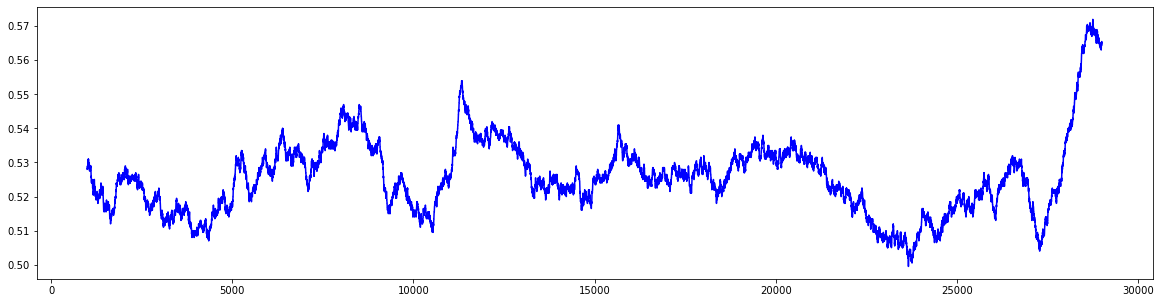

In [164]:
fig, ax = plt.subplots(figsize=(20, 5))
genome = SeqIO.read("data/3.fasta", format="fasta")
rng, gc = gc_content_graph(genome.seq)
ax.plot(rng, np.array(gc), color="blue")
print(gc_content(genome.seq))

([28871, 29617, 'Domains: TS_Pyrimidine_HMase superfamily', 'GFKBJCAA_00036'], False, 0.01)
([27920, 28186, 'hypothetical protein', 'GFKBJCAA_00034'], False, 0.02)


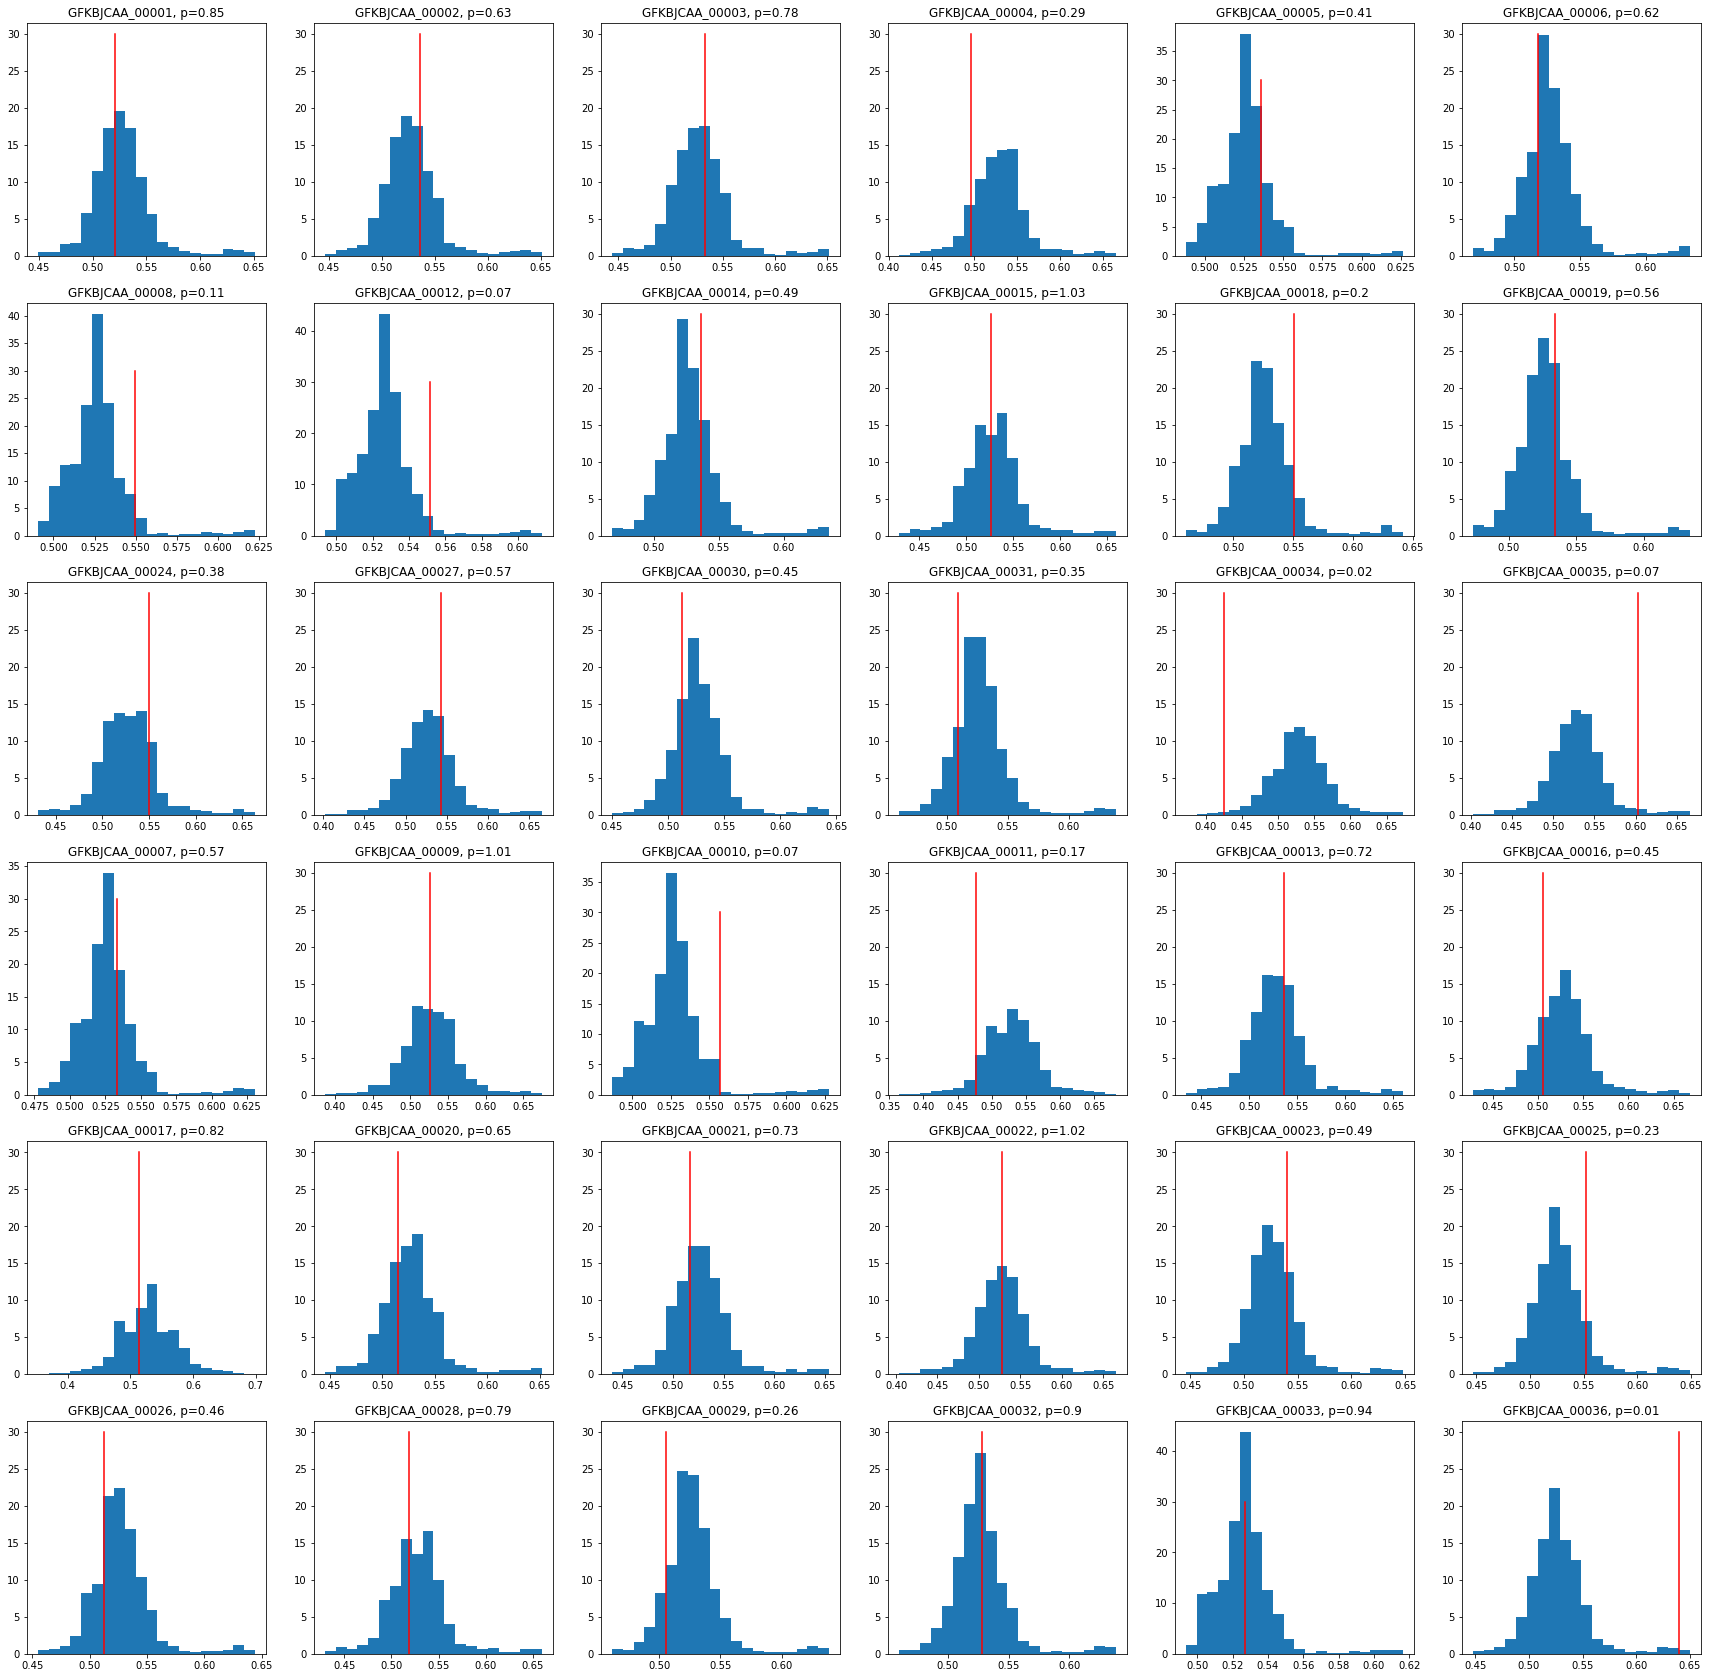

In [155]:
### Testing genes on unusual gc-content
### Multiple comparisons problem is apparent. But if do a Bonferroni correction, I think there is literally no chance for any gene to show significant defiation...

genome = SeqIO.read("data/3.fasta", format="fasta").seq
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(30, 30))
pairs = []
i = 0
candidates = []
for gene_group in all_genes:
    for gene in gene_group[0]:
        gene_seq = genome[gene[0]:gene[1]]
        target = gc_content(gene_seq)
        dummy, distr = gc_content_graph(genome, sliding_window=len(gene_seq))
        distr = np.array(distr)
        p_val = (min((distr >= target).mean(), (distr <= target).mean())*2).round(2) # Multiply by two because we want 2-sided p-value
        ax[i//6, i%6].hist(distr, bins=20, density=True)
        ax[i//6, i%6].plot([target, target], [0, 30], color="red")
        ax[i//6, i%6].set_title(f'{gene[3]}, p={p_val}')
        i += 1
        
        if p_val <= 0.05:#/36: If we want to make a Bonferroni correction. Then we won't get any significant hits.
            is_in_operon = any([gene[0] >= operon[0] and gene[1] <= operon[1] for operon in all_operons])
            candidates.append((gene, is_in_operon, p_val))
fig.savefig("hgt_genes.png")
candidates.sort(key=lambda el: el[2])
for candidate in candidates:
    print(candidate)
with open("Candidates_for_HGT_GC_content.csv", "w") as fl:    
    fl.write(f"ID,Description,p_value,is_part_of_the_operon\n")
    for candidate in candidates:
        fl.write(f'{candidate[0][3]},{candidate[0][2]},{candidate[2]},{candidate[1]}\n')

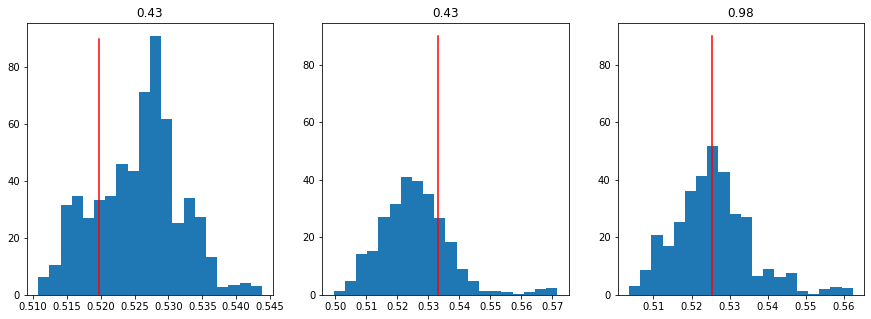

In [27]:
### Same for operons. No significance
genome = SeqIO.read("data/3.fasta", format="fasta").seq
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, operon in enumerate(all_operons):
    operon_seq = genome[operon[0]:operon[1]]
    target = gc_content(operon_seq)
    dummy, distr = gc_content_graph(genome, sliding_window=len(operon_seq))
    distr = np.array(distr)
    p_val = (min((distr >= target).mean(), (distr <= target).mean())*2).round(2) # Multiply by two because we want 2-sided p-value
    ax[i].hist(distr, bins=20, density=True)
    ax[i].plot([target, target], [0, 90], color="red")
    ax[i].set_title(p_val)
fig.savefig("hgt_operons.png")